In [1]:
import numpy as np
import scipy
from scipy import linalg
from matplotlib import pyplot as plt
import functools as ftls
import networkx as nx
import copy
from itertools import combinations
%matplotlib inline
import sys
from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))
np.set_printoptions(threshold=sys.maxsize)

X = np.array([[0.0, 1.0], [1.0, 0.0]])
Y = np.array([[0.0,-1.0j],[1.0j,0.0]], dtype = 'complex')
Z = np.array([[1.0, 0.0], [0.0, -1.0]])
I = np.array([[1.0, 0.0], [0.0, 1.0]])

In [2]:
def new_graph(d, n):
    graph = nx.random_regular_graph(d, n)
    return graph, d, n

def isomorphism_check(x, y):
    isomorphic = nx.is_isomorphic(x, y)
    return isomorphic

def is_graph_connected(g):
    connected = nx.is_connected(g)
    return connected

def is_graph_regular(g, k):
    regular = nx.is_k_regular(g, k)
    return regular

def generate_graphs(num_edges, num_nodes, num_graphs):
    graph_list = []
    connected_graphs = []
    regular_graphs = []
    graph_only =[]
    if num_nodes < 4 and num_edges < 2:
        graph_only.append(new_graph(num_edges,num_nodes))
        return graph_only
    else :
        for i in range(num_graphs):
            graph_list.append(new_graph(num_edges,num_nodes))
        for i in range(len(graph_list)):
            if (is_graph_regular(graph_list[i][0], num_edges)):
                regular_graphs.append(graph_list[i])
        for i in range(len(regular_graphs)):
            if (is_graph_connected(regular_graphs[i][0])):
                connected_graphs.append(regular_graphs[i])
        check = True
        graphs = copy.deepcopy(connected_graphs)
        while (check) and (len(graphs) > 1):
            for i, j in combinations(graphs, 2):
                check = isomorphism_check(i[0], j[0])
                if check:
                    graphs.remove(i)
                    break
        return graphs

In [53]:
def MaxCut_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    for edge in edges:
        edge = np.sort(edge)
        H_problem += np.real(ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, 
                                   np.eye(2**(edge[1]-edge[0]-1)),
                                   operator, np.eye(2**(qubits-edge[1]-1))]))
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def MaxClique_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    graph = nx.Graph(edges)
    graph_c = nx.complement(graph)
    edges_c = graph_c.edges
    for edge in edges_c:
        edge = np.sort(edge)
        H_problem += 3/4 * (np.real(ftls.reduce(np.kron, 
                                   [np.eye(2**edge[0]), operator, np.eye(2**(edge[1]-edge[0]-1)), operator, np.eye(2**(qubits-edge[1]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, np.eye(2**(qubits-edge[0]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**(edge[1])), operator, np.eye(2**(qubits-edge[1]-1))])))
    for j in range(qubits):
        H_problem += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def Hamiltonian_d(qubits, operator):
    H_driver = np.zeros([2**qubits]*2, dtype = operator.dtype)
    for j in range(qubits):
        H_driver += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    return H_driver

def eigenVectors(Hamilt):
    eigenValues, eigenVectors = np.linalg.eig(Hamilt)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenVectors

def eigenValues(Hamilt):
    eigenValues, eigenVectors = np.linalg.eig(Hamilt)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues

def commutator(A, B, anti = False):
    if not anti:
        return A @ B - B @ A
    elif anti:
        return A @ B + B @ A

def exeFALQON(graphs, qubits):
    h_p_values = []
    graph_for_FALQON =[]
    beta_values = []
    cost_function_values = []
    phi_values = []
    psi_values = []
    H_p_eigenValues = []
    g = 0
    print(len(graphs))
    for g in range(len(graphs)):
        graph_for_FALQON = graphs[g]
        #H_p = MaxCut_p(graph_for_FALQON[0].edges, qubits, Z)
        H_p = MaxClique_p(graph_for_FALQON[0].edges, qubits, Z)
        h_p_values.append(H_p)
        H_d = Hamiltonian_d(qubits, X)
        eigenVectors_p = eigenVectors(H_p)
        eigenValues_p = eigenValues(H_p)
        eigenVectors_d = eigenVectors(H_d)
        eigenValues_d = eigenValues(H_d)
        dt = 0.00425 #Time step
        n_steps = 100 #Number of steps
        beta = [0] #Empty array to store betas with the 0th element being 0
        psi_list = []
        phi_list = []
        
        psi_0 = eigenVectors_d[:, 0]
        U_p = linalg.expm(-1j*H_p*dt) #Unitary for Problem
        comm = 3 * (1j*commutator(H_d, H_p, anti = False))
        cost_function = [float(np.real(np.conj(np.transpose(psi_0)) @ H_p @ psi_0))]#
        U_d = linalg.expm(-1j*beta[0]*H_d*dt) #Unitary for Driver
        psi = U_d @ U_p @ psi_0 #Create psi with initial psi
        A = float(np.real(np.conj(np.transpose(psi)) @ comm @ psi))
        beta.append(-A) #Add -A to beta array
        cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
    
        i = 1 #Already set the first layer, this is for each layer after
        while i < n_steps:
            U_d = linalg.expm(-1j*beta[i]*H_d*dt) #Create Unitary Driver
            psi = U_d @ U_p @ psi #Create psi
            A = float((np.real(np.conj(np.transpose(psi)) @ comm @ psi)))#Estimate A
            beta.append(-A) #Add -A to beta array
            cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
            psi_list.append(psi)
        
            k = 0
            phi = 0
            for k in range(len(eigenValues_p)):
                if eigenValues_p[0] == eigenValues_p[k]:
                    phi =+ phi + ((np.absolute(np.vdot(eigenVectors_p[:,k], psi)))**2)
            phi_list.append(phi)
            i = i+1 #increment i
        beta_values.append(beta)
        cost_function_values.append(cost_function)
        phi_values.append(phi_list)
        psi_values.append(psi_list)
        H_p_eigenValues.append(eigenValues_p)
    return beta_values, cost_function_values, phi_values, H_p_eigenValues, graphs

In [79]:
k = 3
qubits = 8
num_graphs = 20
#edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
#graphs = nx.Graph(edges)
graphs = generate_graphs(k, qubits, num_graphs)

In [45]:
beta, cost_function, phi_list, eigenValues_p, num_graphs = exeFALQON(graphs, qubits)

5


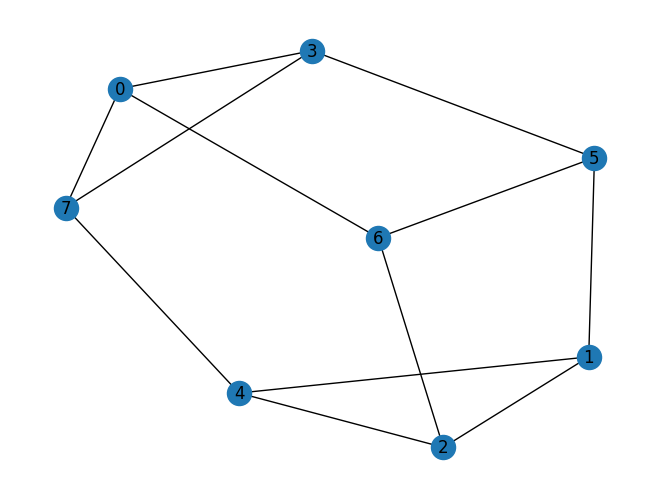

In [91]:
nx.draw(graphs[2][0], with_labels = True)

In [87]:
type(graphs[0][0])

networkx.classes.graph.Graph

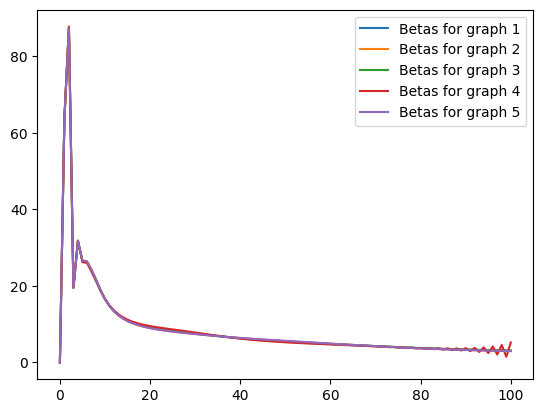

In [46]:
plt.plot(beta[0], label = "Betas for graph 1")
plt.plot(beta[1], label = "Betas for graph 2")
plt.plot(beta[2], label = "Betas for graph 3")
plt.plot(beta[3], label = "Betas for graph 4")
plt.plot(beta[4], label = "Betas for graph 5")
plt.legend()
plt.show()

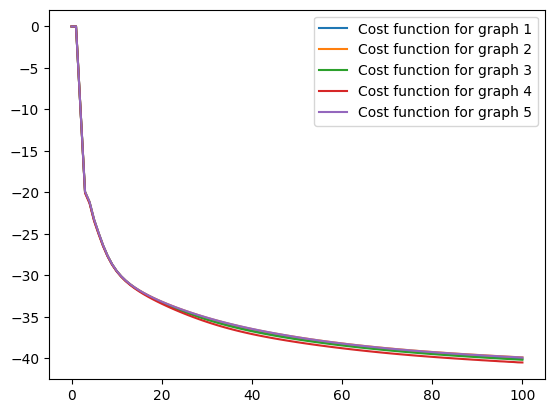

In [47]:
plt.plot(cost_function[0], label = "Cost function for graph 1")
plt.plot(cost_function[1], label = "Cost function for graph 2")
plt.plot(cost_function[2], label = "Cost function for graph 3")
plt.plot(cost_function[3], label = "Cost function for graph 4")
plt.plot(cost_function[4], label = "Cost function for graph 5")
plt.legend()
plt.show()

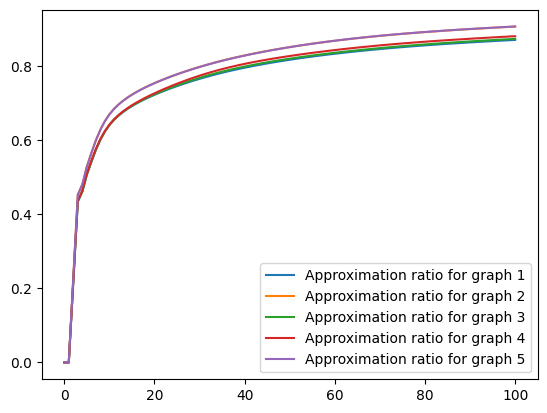

In [48]:
approximation_ratio1 = cost_function[0]/eigenValues_p[0][0]
approximation_ratio2 = cost_function[1]/eigenValues_p[1][0]
approximation_ratio3 = cost_function[2]/eigenValues_p[2][0]
approximation_ratio4 = cost_function[3]/eigenValues_p[3][0]
approximation_ratio5 = cost_function[4]/eigenValues_p[4][0]
plt.plot(approximation_ratio1, label = "Approximation ratio for graph 1")
plt.plot(approximation_ratio2, label = "Approximation ratio for graph 2")
plt.plot(approximation_ratio3, label = "Approximation ratio for graph 3")
plt.plot(approximation_ratio4, label = "Approximation ratio for graph 4")
plt.plot(approximation_ratio5, label = "Approximation ratio for graph 5")
plt.legend()
plt.show()

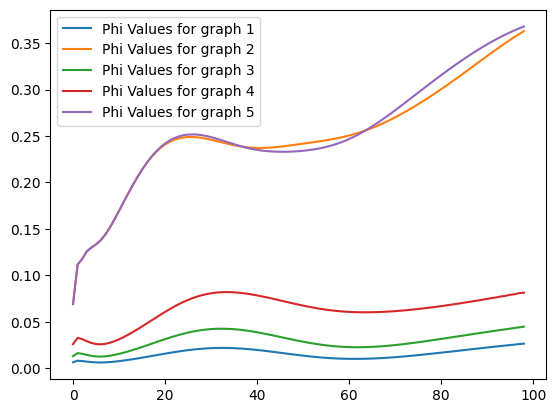

In [49]:
plt.plot(phi_list[0], label = "Phi Values for graph 1")
plt.plot(phi_list[1], label = "Phi Values for graph 2")
plt.plot(phi_list[2], label = "Phi Values for graph 3")
plt.plot(phi_list[3], label = "Phi Values for graph 4")
plt.plot(phi_list[4], label = "Phi Values for graph 5")
plt.legend()
plt.show()

In [54]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graphs = nx.Graph(edges)
H1 = MaxClique_p(edges, 5, Z)

In [51]:
H2 = np.real(
   (np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*0.75) +
    (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
    (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*0.75) +
    (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*0.75) +
    (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*0.25) +
    (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*0.75) +
    (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*0.25) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
    (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*0.75))

In [55]:
linalg.norm(H1-H2)
print(np.diag(H1).tolist(), np.diag(H2).tolist(), sep='\n')
np.diag(H1)/np.diag(H2)

[1.25, -0.75, -0.75, 0.25, -0.75, 0.25, -2.75, 1.25, -0.75, -2.75, 0.25, 1.25, -2.75, -1.75, -1.75, 2.25, -0.75, 0.25, 0.25, 4.25, -2.75, 1.25, -1.75, 5.25, -2.75, -1.75, 1.25, 5.25, -4.75, -0.75, -0.75, 6.25]
[1.25, -0.75, -0.75, 0.25, -0.75, 0.25, -2.75, 1.25, -0.75, -2.75, 0.25, 1.25, -2.75, -1.75, -1.75, 2.25, -0.75, 0.25, 0.25, 4.25, -2.75, 1.25, -1.75, 5.25, -2.75, -1.75, 1.25, 5.25, -4.75, -0.75, -0.75, 6.25]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [27]:
Cost Hamiltonian
  (-1.25) [Z3]
+ (-1.25) [Z4]
+ (-0.5) [Z0]
+ (0.25) [Z1]
+ (0.25) [Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z0 Z4]
+ (0.75) [Z1 Z3]
+ (0.75) [Z2 Z4]
+ (0.75) [Z3 Z4]

SyntaxError: invalid syntax (3914810064.py, line 1)

In [71]:
len(beta)

5

In [74]:
def MaxCut_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    for edge in edges:
        edge = np.sort(edge)
        H_problem += np.real(ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, 
                                   np.eye(2**(edge[1]-edge[0]-1)),
                                   operator, np.eye(2**(qubits-edge[1]-1))]))
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def MaxClique_p(edges, qubits, operator):
    H_problem = np.zeros([2**qubits,2**qubits], dtype=operator.dtype)
    graph = nx.Graph(edges)
    graph_c = nx.complement(graph)
    edges_c = graph_c.edges
    for edge in edges_c:
        edge = np.sort(edge)
        H_problem += 3/4 * (np.real(ftls.reduce(np.kron, 
                                   [np.eye(2**edge[0]), operator, np.eye(2**(edge[1]-edge[0]-1)), operator, np.eye(2**(qubits-edge[1]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**edge[0]), operator, np.eye(2**(qubits-edge[0]-1))]) -
                                   ftls.reduce(np.kron, [np.eye(2**(edge[1])), operator, np.eye(2**(qubits-edge[1]-1))])))
    for j in range(qubits):
        H_problem += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    if np.isreal(H_problem).all():
        H_problem = H_problem.real
    return H_problem

def Hamiltonian_d(qubits, operator):
    H_driver = np.zeros([2**qubits]*2, dtype = operator.dtype)
    for j in range(qubits):
        H_driver += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), operator, np.eye(2**(qubits-j-1))])
    return H_driver

def eigenVectors(Hamilt):
    eigenValues, eigenVectors = np.linalg.eig(Hamilt)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenVectors

def eigenValues(Hamilt):
    eigenValues, eigenVectors = np.linalg.eig(Hamilt)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues

def commutator(A, B, anti = False):
    if not anti:
        return A @ B - B @ A
    elif anti:
        return A @ B + B @ A

def exeFALQON(qubits):
    h_p_values = []
    graph_for_FALQON =[]
    beta_values = []
    cost_function_values = []
    phi_values = []
    psi_values = []
    H_p_eigenValues = []
    #H_p = MaxCut_p(graph_for_FALQON[0].edges, qubits, Z)
    #H_p = MaxClique_p(edges, qubits, Z)
    H_p = np.real(
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*0.75) +
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*0.75) +
            (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*0.75) +
            (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*0.25) +
            (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*0.75) +
            (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*0.25) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*0.75))
    h_p_values.append(H_p)
    H_d = Hamiltonian_d(qubits, X)
    eigenVectors_p = eigenVectors(H_p)
    eigenValues_p = eigenValues(H_p)
    eigenVectors_d = eigenVectors(H_d)
    eigenValues_d = eigenValues(H_d)
    dt = 0.03 #Time step
    n_steps = 40 #Number of steps
    beta = [0] #Empty array to store betas with the 0th element being 0
    psi_list = []
    phi_list = []
        
    psi_0 = eigenVectors_d[:, 0]
    U_p = linalg.expm(-1j*H_p*dt) #Unitary for Problem
    comm1 = 3 * (1j*commutator(H_d, H_p, anti = False))
    print(comm1)
    print("hello")
    comm = ((np.kron(I, np.kron(I, np.kron(I, np.kron(Y, I))))*(-12)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Y))))*(-12)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(I, I))))*(-6)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(Z, I))))*(6)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(I, Z))))*(6)) +
        (np.kron(I, np.kron(Y, np.kron(I, np.kron(Z, I))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(Y, np.kron(I, Z))))*(6)) +
        (np.kron(Z, np.kron(I, np.kron(I, np.kron(Y, I))))*(6)) +
        (np.kron(I, np.kron(Z, np.kron(I, np.kron(Y, I))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(Y, Z))))*(6)) +
        (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Y))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Y))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Y))))*(6)))
    cost_function = [float(np.real(np.conj(np.transpose(psi_0)) @ H_p @ psi_0))]#
    U_d = linalg.expm(-1j*beta[0]*H_d*dt) #Unitary for Driver
    psi = U_d @ U_p @ psi_0 #Create psi with initial psi
    A = float(np.real(np.conj(np.transpose(psi)) @ comm @ psi))
    beta.append(-A) #Add -A to beta array
    cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
    
    i = 1 #Already set the first layer, this is for each layer after
    while i < n_steps:
        U_d = linalg.expm(-1j*beta[i]*H_d*dt) #Create Unitary Driver
        psi = U_d @ U_p @ psi #Create psi
        A = float((np.real(np.conj(np.transpose(psi)) @ comm @ psi)))#Estimate A
        beta.append(-A) #Add -A to beta array
        cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
        psi_list.append(psi)
        
        k = 0
        phi = 0
        for k in range(len(eigenValues_p)):
            if eigenValues_p[0] == eigenValues_p[k]:
                phi =+ phi + ((np.absolute(np.vdot(eigenVectors_p[:,k], psi)))**2)
        phi_list.append(phi)
        i = i+1 #increment i
    beta_values.append(beta)
    cost_function_values.append(cost_function)
    phi_values.append(phi_list)
    psi_values.append(psi_list)
    H_p_eigenValues.append(eigenValues_p)
    return beta_values, cost_function_values, phi_values, H_p_eigenValues, graphs

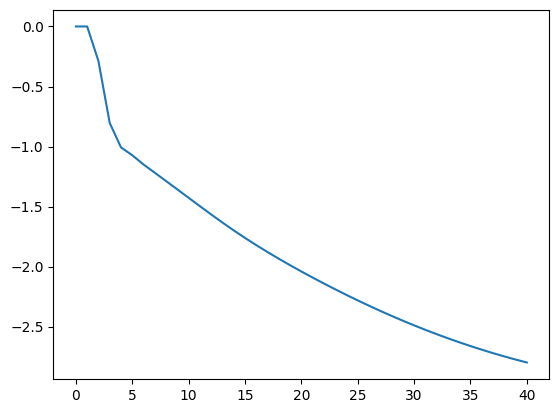

In [61]:
cost_function = exeFALQON(5)[1]
plt.plot(cost_function[0])
plt.show()

In [62]:
H_p = np.real(
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(Z, I))))*0.75) +
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, I))))*(-0.5)) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, I))))*(-1.25)) +
            (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Z))))*0.75) +
            (np.kron(I, np.kron(Z, np.kron(I, np.kron(Z, I))))*0.75) +
            (np.kron(I, np.kron(Z, np.kron(I, np.kron(I, I))))*0.25) +
            (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Z))))*0.75) +
            (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, I))))*0.25) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Z))))*(-1.25)) +
            (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Z))))*0.75))

comm1 = ((np.kron(I, np.kron(I, np.kron(I, np.kron(Y, I))))*(-12)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(I, Y))))*(-12)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(I, I))))*(-6)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(Z, I))))*(6)) +
        (np.kron(Y, np.kron(I, np.kron(I, np.kron(I, Z))))*(6)) +
        (np.kron(I, np.kron(Y, np.kron(I, np.kron(Z, I))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(Y, np.kron(I, Z))))*(6)) +
        (np.kron(Z, np.kron(I, np.kron(I, np.kron(Y, I))))*(6)) +
        (np.kron(I, np.kron(Z, np.kron(I, np.kron(Y, I))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(Y, Z))))*(6)) +
        (np.kron(Z, np.kron(I, np.kron(I, np.kron(I, Y))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(Z, np.kron(I, Y))))*(6)) +
        (np.kron(I, np.kron(I, np.kron(I, np.kron(Z, Y))))*(6)))
print(comm1)

[[ 0. +0.j  0. -6.j  0. -6.j  0. +0.j  0. -6.j  0. +0.j  0. +0.j  0. +0.j
   0. -6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. -6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +6.j  0. +0.j  0. +0.j  0. +6.j  0. +0.j  0. +6.j  0. +0.j  0. +0.j
   0. +0.j  0. -6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j  0. +6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +6.j  0. +0.j  0. +0.j  0. +6.j  0. +0.j  0. +0.j  0. -6.j  0. +0.j
   0. +0.j  0. +0.j  0. +6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j  0. +0.j  0. +6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. -6.j  0. -6.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +6.j
   0. +0.j  0. +0.j  0. +0.j  0. +6

In [75]:
exeFALQON(5)

[[0. +0.j 0. -6.j 0. -6.j 0. +0.j 0. -6.j 0. +0.j 0. +0.j 0. +0.j 0. -6.j
  0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. -6.j 0. +0.j
  0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
  0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +6.j 0. +0.j 0. +0.j 0. +3.j 0. +0.j 0. +3.j 0. +0.j 0. +0.j 0. +0.j
  0. -6.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +3.j
  0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
  0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +6.j 0. +0.j 0. +0.j 0. +3.j 0. +0.j 0. +0.j 0. -6.j 0. +0.j 0. +0.j
  0. +0.j 0. +3.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
  0. +3.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
  0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. -3.j 0. -3.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +3.j 0. +0.j
  0. +0.j 0. +0.j 0. +3.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j
  0. +0.j 0.+12.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j

([[0,
   4.662884291094987,
   8.086667707413369,
   5.366758232663744,
   2.4051450532972805,
   2.7985250536587936,
   2.573673025847009,
   2.580556667338279,
   2.5408396367886774,
   2.513262045800121,
   2.4651854491497462,
   2.39673012860428,
   2.30724993214333,
   2.20356456090895,
   2.0946778104481383,
   1.9890102418368043,
   1.8921435163065095,
   1.8066350707371912,
   1.7328202774486066,
   1.669791081450285,
   1.6161097633290007,
   1.5702401232744534,
   1.5307667181090612,
   1.4964899820118467,
   1.466449122557397,
   1.4399094079346602,
   1.4163298061058156,
   1.395323753869849,
   1.3766163666093834,
   1.3600040071585031,
   1.345315653023688,
   1.3323808150013035,
   1.3210016128423745,
   1.3109347566935294,
   1.3018787783571883,
   1.2934748056437355,
   1.2853117165620158,
   1.276948591004916,
   1.267935900208336,
   1.2578572763743214,
   1.2463551578338363]],
 [[4.440892098500626e-16,
   6.661338147750939e-16,
   -0.2877523102355861,
   -0.80350683